# Stock predictions with Holt-Winters model

For a real-world exercise on stock predictions, you will use the S&P 500 dataset of Open, High, Low, Close, Adj Close and Volume stock price information for 104 international companies, e.g. 'GOOG' stands for Google. Each company is stacked on top of each other in the dataset, where each row records daily values from 2010 to 2019. 

Since you are dealing with time series, each feature is considered an individual time series, so you need to filter the dataset to a company of your choice, e.g. 'GOOG', and a time series of your choice, e.g. 'Close'. Then you can build a model to forecast for future closing stock prices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
df = pd.read_csv('data/sp500sub.csv', index_col='Date', parse_dates=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [9]:
# Drop all NaN rows

df = df.dropna()

In [13]:
# Google stock prices (2,263 rows)

df[df['Name'] == 'GOOG']

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927000.0,GOOG
2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031900.0,GOOG
2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987100.0,GOOG
2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876600.0,GOOG
2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9483900.0,GOOG
...,...,...,...,...,...,...,...
2018-12-21,1015.299988,1024.020020,973.690002,979.539978,979.539978,4596000.0,GOOG
2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300.0,GOOG
2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300.0,GOOG


In [14]:
# Look at Googles daily close time series 

goog = df[df['Name'] == 'GOOG'][['Close']].copy()

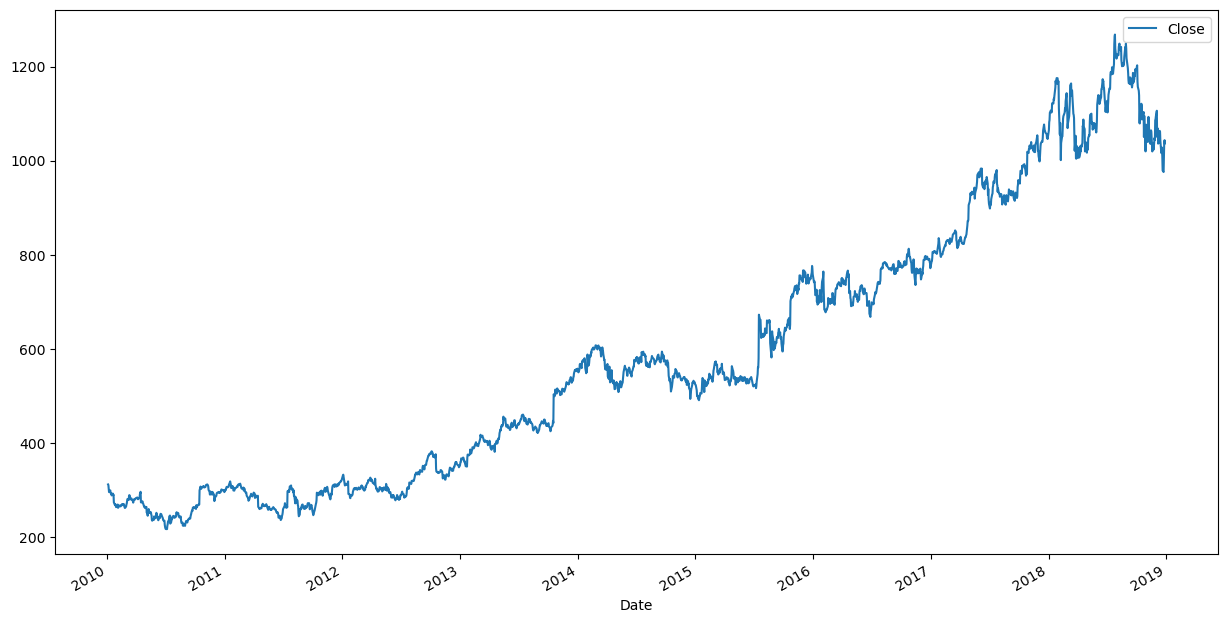

In [15]:
goog.plot(figsize=(15, 8));

In [16]:
# Look at Googles log of closes

goog['LogClose'] = np.log(goog['Close'])

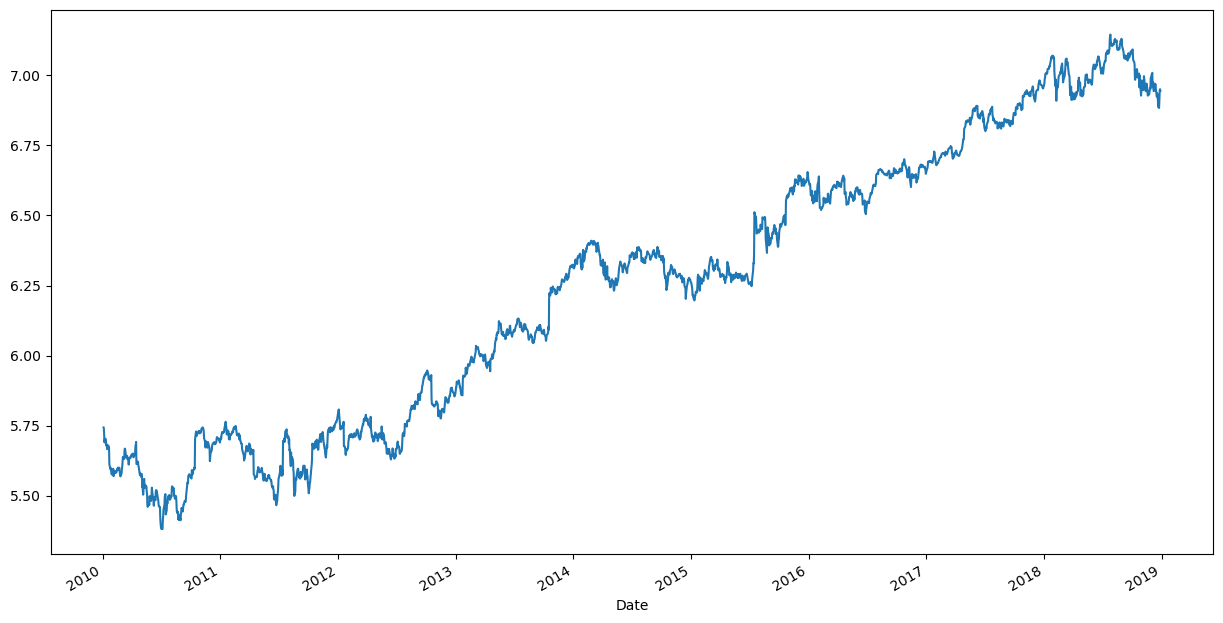

In [17]:
goog['LogClose'].plot(figsize=(15, 8));

**The plots look very similar in behaviour, with the log transform revealing a positive linear trend, with little or no indication of seasonality (too many changes over time without any pattern).**

**We can use the log transform with the stock predictions, i.e. no need to use Box-Cox transformation (`use_boxcox=False`).**

## Build Holt-Winters model

Due to the stock takings recorded on trading days, there are gaps in the timeline which the `freq` attribute cannot cope with, i.e. the weekend or bank holidays, so you have to manually add frequency to the time series or make do without a frequency, which will raise a UserWarning message.

NOTE: Usually you can use Pandas `asfreq()` function to infer business day frequency but it is not working with this time series due to the unusual gaps. There should be an additional argument for trading days in Pandas!

In [28]:
# Set index frequency - THIS DOESN'T WORK!!!

#goog.index.freq = 'B'

In [30]:
# Create training and test sets

N_test = 30

train = goog.iloc[:-N_test]
test = goog.iloc[-N_test:]

In [31]:
# Boolean index time series to index df rows

train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [33]:
# Instantiate model and train (you will get warning)

hw = ExponentialSmoothing(train['LogClose'], initialization_method='legacy-heuristic', trend='add', seasonal=None)

res_hw = hw.fit()

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
# Assign train predictions to DataFrame

goog.loc[train_idx, 'Holt-Winters_train'] = res_hw.fittedvalues

In [35]:
# Assign test predictions array to DataFrame - convert predictions to NumPy due to no frequency

goog.loc[test_idx, 'Holt-Winters_test'] = res_hw.forecast(N_test).to_numpy()

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


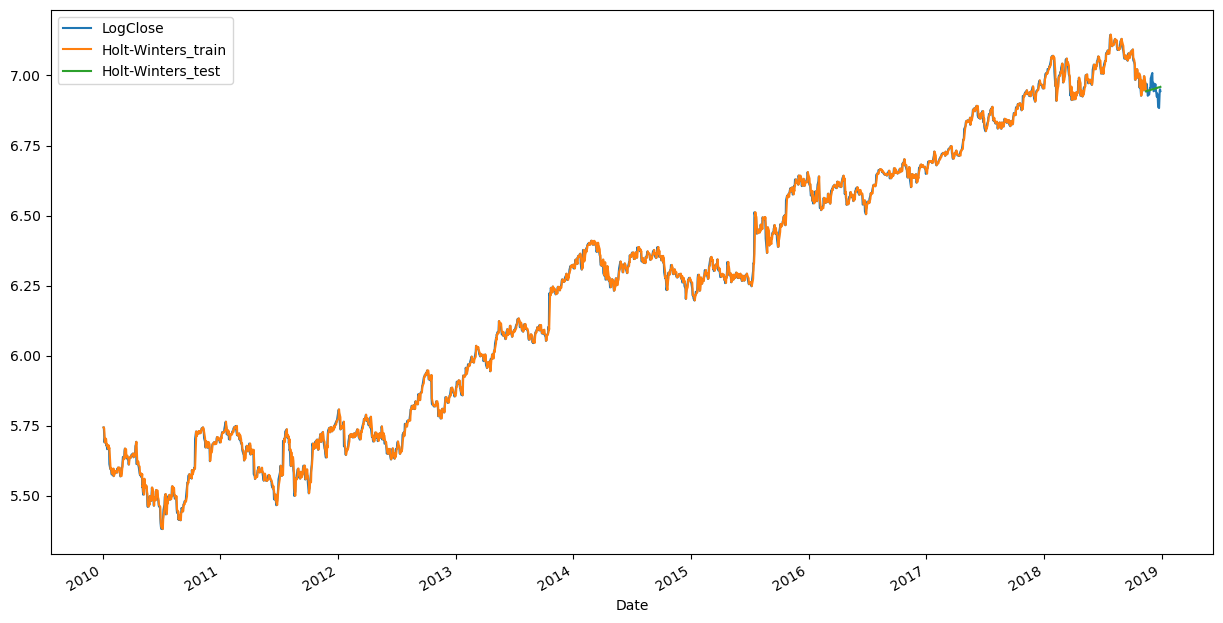

In [36]:
goog[['LogClose', 'Holt-Winters_train', 'Holt-Winters_test']].plot(figsize=(15, 8));

**Despite not being able to compute the frequency of the timesteps, the training predictions match the time series very well, but do not be fooled as it is the test predictions that matter. You can look more closely at the latest time period to get a better idea of what is going on, e.g. the last 100 trading days.**

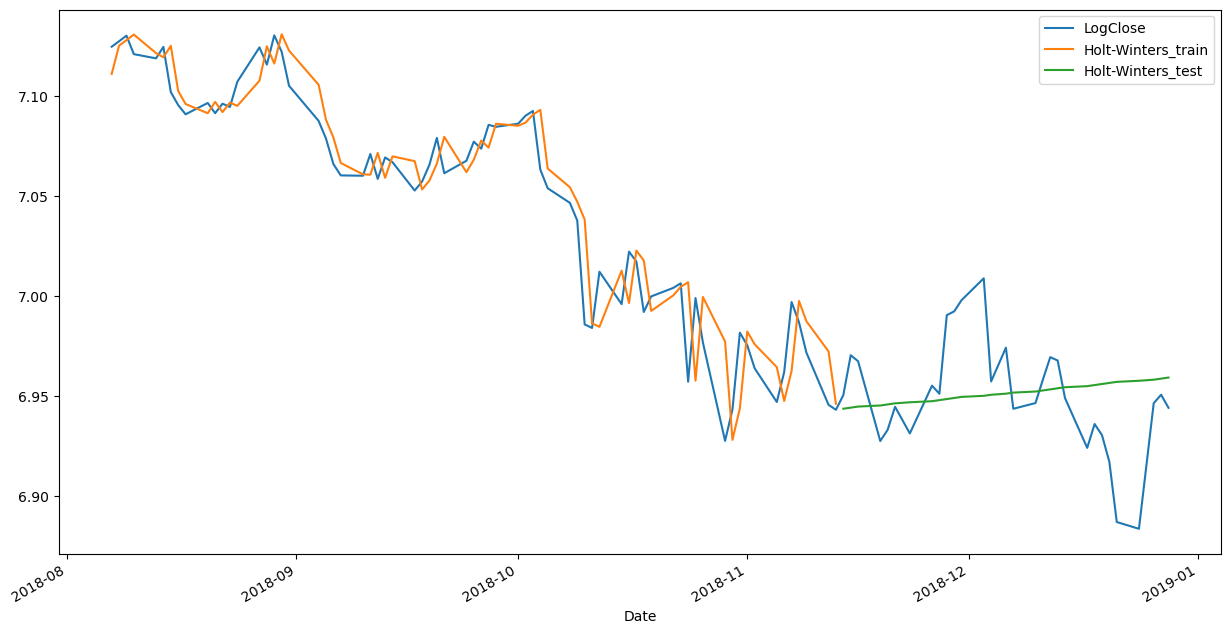

In [37]:
# Zoom into the last 100 timesteps of the series

cols = ['LogClose', 'Holt-Winters_train', 'Holt-Winters_test']

goog.iloc[-100:][cols].plot(figsize=(15, 8));

**The training set performs so well because it is predicting the last value - notice the lag. The forecast is based on trend only, and looks almost horizontal, so Holt-Winters model may be using naive forecasting, i.e. tomorrow's value is same as todays.**

**If you perform naive forecasting, you can assess how much of a trend is captured by Holt-Winters model.**

## Perform naive forecasting

Remember that we propagate the future value through the last known value.


In [38]:
goog.loc[test_idx, 'Naive'] = train.iloc[-1]['LogClose']

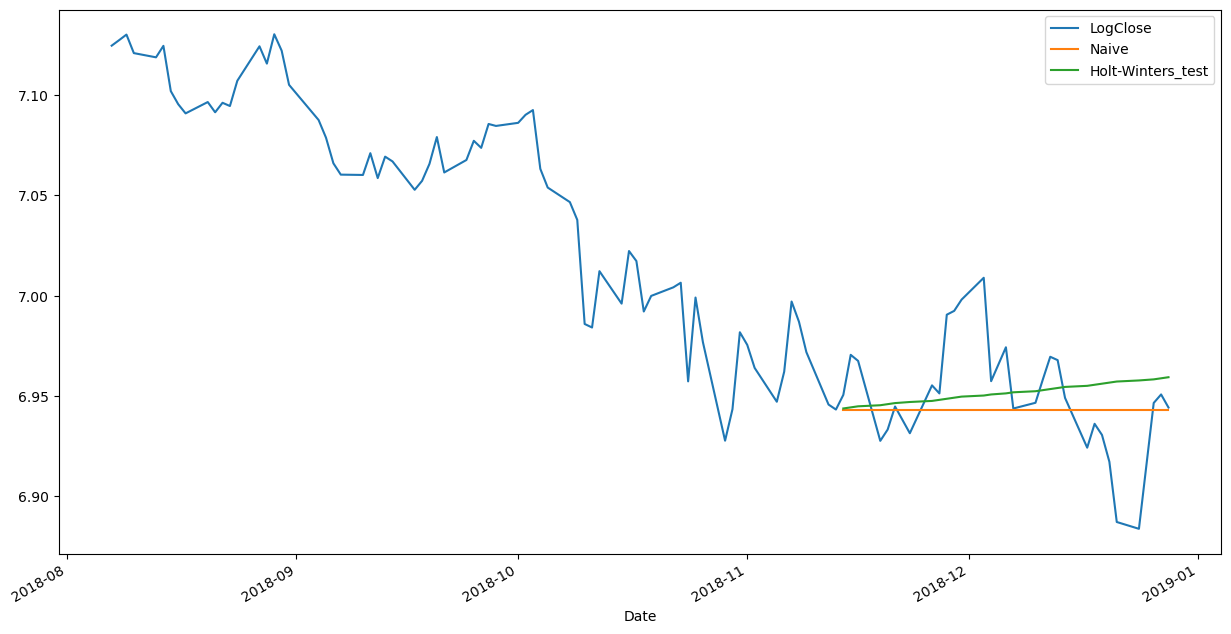

In [39]:
# Plot last 100 timesteps to view impact of naive forecasting

goog.iloc[-100:][['LogClose', 'Naive', 'Holt-Winters_test']].plot(figsize=(15, 8));

**As you can see, naive forecasting generates a horizontal line, i.e. last known value repeated. This shows that Holt-Winters model does capture the linear trend in the time series data. You can also compare the naive forecasting values with Holt-Winters predictions using SciKit-Learn performance metrics.**

In [40]:
# Compare naive forecasting to Holt-Winters

print("Naive R-squared:", r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'Naive']))

Naive R-squared: -0.06454209862026317


In [41]:
print("Holt-Winters R-squared:", r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'Holt-Winters_test']))

Holt-Winters R-squared: -0.15876524787484114


**Looks like naive forecasting performs better than additive trend model, but neither model fits the data well due to the negative sign. As a conclusion, Holt-Winters model fits worse than a horizontal line because it is more negative. It would be better to try another time series model for forecasting.**